# Batch processing of pixel extraction.

## NOTE: Remember to enable the following line in the *beam.config* file by removing the hash.

    beam.envisat.usePixelGeoCoding = true   


In [1]:
__credits__ = ["José M. Beltrán"]
__license__ = "GPL-3.0"
__created_on__ = ["2012-05-02"]
__modified_on__ = { "2014-12-09": ["Updated workflow by using which_megs_l2_flags_NetCDF function"]
                    "2014-10-22": ["Added Turbidity_Nechad_620"]
                    "2014-10-16": ["Batch process targeting Turbidity"], 
                    "2013-10-22": ["New GPT graph. The BEAM VISAT version 4.11 does not include anymore the inputPaths whithin the graph it has changed to: &lt;sourceProductPaths&gt;"], 
                    "2013-10-17": ["reintroduced for Selima and Evgeny: - xml_skeleton,- the get_fub_srcList "], 
                    "2012-06-18": ["xml_skeletons were replaced by gpt_skeletons", "introduced common.get_fub_srcList(srcDir) function", "introduced get_pins_srcList"]}

__accompanying_paper__ : ["Kari et al Turbidity"]

__preceding_notebooks__ : ["create_placemarks_using_centroids", "pixel_extraction_centroids_MEGS-reflec_06","building_insitu_mongoDB"]
__anticipate_notebooks __ : [[Method 4 Elina's] Turbidity and SPM validation-Validation_SPM_with_Matchups]

In [1]:
import sys
import os.path
from sys import argv, exit
# Using the MathJax library to display the Latex.
from IPython.display import Math
#from time import localtime, strftime

In [2]:
from files.regex_filename import get_MERIS_date_string_from_filename
## Looking for the source MEGS files N1
processor = "MEGS"
srcDir = "/media/jobel/SeagateDrive/eodata2014/level2/"+processor+"/"
srcDates = {}
# Adding recursive walk for directories
for dirpath, dirnames, files in os.walk(srcDir):
    for file in files:  # files is a list of files in the current directory
        if file.startswith('MER_') and file.endswith(".nc"):  #".N1"
            currentFilepath = dirpath
            date_string = get_MERIS_date_string_from_filename(file)
            srcDates[date_string] = {"filepath":os.path.join(currentFilepath, file)}             
            
sorted(srcDates)
print(len(srcDates), "dates available")# len(matchups), " matchups available")


(436, 'dates available')


In [3]:
# Function to get the input pin list
def get_pins_dict(srcDir):
    # Another MAGIC function that saves a lot of time =)
    pin_dict = {}
    for dirpath, dirnames, files in os.walk(srcDir):
        for file in files:  # files is a list of files in the current directory
            if file.startswith('pin_2') and file.endswith(".placemark"):
                date_string = file[4:12]  # This extract the date from the filename of pins             
                currentFilepath = dirpath
                pin_dict[date_string] = os.path.join(currentFilepath, file)
    return pin_dict

In [4]:
# Creating the pins_dictionay
pinSrcDir = '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_from_centroids/'
pin_dict = get_pins_dict(pinSrcDir)

In [5]:
# Create a dictionary that pairs MERIS with pins dates within a time window of 2 days.
def time_window_match(meris_date_list, insitu_date_list, delta_days = 2):
    # returns a dictinary with MERIS dates as keys and Insitu date as values.
    from utils.transform_datetime import matchup_window_date_list_around_date
    # Looking for match-ups in a match-up window of 2 days. Note making the window up to 3 days was not useful
    insitu_matched_dates = {}    
    for date_string in insitu_date_list:
        insitu_matched_dates[date_string] = []
        if date_string in meris_date_list:
            insitu_matched_dates[date_string].append(date_string)
        else:
            matchup_window_dates = matchup_window_date_list_around_date(date_string, delta_days=2)        
            for dm in matchup_window_dates:
                if dm in meris_date_list:
                    insitu_matched_dates[date_string].append(dm)
    #print insitu_matched_dates
    # Swaping the dictionary matched_dates and filtering empty dates
    meris_matched_dates = dict ( (v[0],k) for k, v in insitu_matched_dates.items() if v != [])
    return meris_matched_dates#insitu_matched_dates

In [6]:
meris_date_list = srcDates.keys()
insitu_date_list = pin_dict.keys()
meris_matched_dates = time_window_match(meris_date_list, insitu_date_list, delta_days = 2)
meris_matched_dates

{'20100818': '20100817', '20100820': '20100820', '20110715': '20110717'}

In [7]:
# Filtering the available meris files and pin files based on matched_dates.
matched_files = {}
for date_string in meris_matched_dates.keys():
    pin_file = pin_dict[meris_matched_dates[date_string]]
    matched_files[date_string] = {'MERIS':srcDates[date_string]['filepath'], 'PIN_FILE':pin_file}
    #
matched_files

{'20100818': {'MERIS': '/media/jobel/SeagateDrive/eodata2014/level2/MEGS/20100818_092514/output/MER_FSG_2PNMAP20100818_092514_000000392092_00122_44264_0001.nc',
  'PIN_FILE': '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_from_centroids/pin_20100817_batched.placemark'},
 '20100820': {'MERIS': '/media/jobel/SeagateDrive/eodata2014/level2/MEGS/20100820_100208/output/MER_FSG_2PNMAP20100820_100208_000000422092_00151_44293_0001.nc',
  'PIN_FILE': '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_from_centroids/pin_20100820_batched.placemark'},
 '20110715': {'MERIS': '/media/jobel/SeagateDrive/eodata2014/level2/MEGS/20110715_094413/output/MER_FSG_2PNMAP20110715_094413_000000423104_00295_49016_0001.nc',
  'PIN_FILE': '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_from_centroids/pin_20110717_batched.placemark'}}

In [8]:
windowSize="3"

current_gpt_graph = '/home/jobel/Dropbox/ElinasPaper/gpt_graph/current_gpt_graph.xml'
destDir = '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pixEX_centroids/'+processor +'/'+ windowSize +'x'+windowSize +'/'

# Loading the pixel extraction files

In [9]:
import numpy as np
import pandas as pd

# Creating the available pixel extraction files
srcDir = '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pixEX_centroids/'+processor +'/'+ windowSize +'x'+windowSize +'/'
pixEx_file_list = []
# Adding recursive walk for directories
for dirpath, dirnames, files in os.walk(srcDir):
    for file in files:  # files is a list of files in the current directory
        if file.endswith("_measurements.txt"):
            currentFilepath = dirpath
            pixEx_file_list.append(os.path.join(currentFilepath, file))   
pixEx_file_list
            

['/home/jobel/Dropbox/ElinasPaper/data_4_elina/pixEX_centroids/MEGS/3x3/pixEx_20110715_centroid_3x3_MEGS__CF-1.4_measurements.txt',
 '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pixEX_centroids/MEGS/3x3/pixEx_20100820_centroid_3x3_MEGS__CF-1.4_measurements.txt',
 '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pixEX_centroids/MEGS/3x3/pixEx_20100818_centroid_3x3_MEGS__CF-1.4_measurements.txt']

In [10]:
from files.regex_filename import get_MERIS_date_string_from_filename
# The pixEx files have a 6 head lines in the file that must be removed.
head_lines = 6 
pix_data = {}

for nf,filename in enumerate(pixEx_file_list):
    current_file = filename
    # Get the date value from the PixEX filename
    date_string = get_MERIS_date_string_from_filename(current_file)
    with open(current_file, 'r') as fr:
        #skipping headlines
        for i in xrange(head_lines):
            fr.next()
        column_headers = fr.next().strip('\n').split('\t') # Gets the column headers
        column_headers[7:9] = ['Date','Time'] # Changing header names to have only non special characters
        # The Date and Time fields are not reliable, therefore we must add our own column with a date_string
        column_headers.append("meris_date")
        column_headers.append("insitu_date")
        pix_data[date_string] = dict([(key,[]) for key in column_headers])        
              
        for nr,  row_line in enumerate(fr):
            for column, value in enumerate(row_line.strip('\n').split('\t')):
                if column_headers[column] == 'reflectance_06':
                    if value != "":
                        pix_data[date_string][column_headers[column]].append(float(value))
                    else:
                        pix_data[date_string][column_headers[column]].append(np.nan)
                else:
                    pix_data[date_string][column_headers[column]].append(value)
            # Appending the date_string to keep track of the source file
            pix_data[date_string]["meris_date"].append(date_string)
            # Appending the related insitu_date for match-up
            pix_data[date_string]["insitu_date"].append(meris_matched_dates[date_string])
        


In [11]:
# Joining the tables
# Merging the dictionaries as panda dataframes
# Using MEGS the reflectance_06 value is for Case-1 waters. The bands "nrrs_06", "c2r_RLw_06" comes from the intermediate products
# of the Case-2 branch, and those were u
keep_columns = ["meris_date","insitu_date","Name","CoordID",'l2_flags',"nrrs_06", "reflectance_06"]
#keep_columns = ["meris_date","insitu_date","Name","CoordID",'result_flags','l1p_flags','total_susp', 'pins']

dataHolder = pd.DataFrame(columns=[keep_columns])
for key in pix_data.keys():
    dataHolder = pd.merge(dataHolder, pd.DataFrame(pix_data[key])[keep_columns],how='outer' )

# releasing memory
pix_data = None
#
dataHolder[:3] # showing only the first three elements

,meris_date,insitu_date,Name,CoordID,l2_flags,nrrs_06,reflectance_06
0,20110715,20110717,S126,1,3621904,-0.01568703167140484,-0.048585
1,20110715,20110717,S126,1,3621904,-0.007852844893932343,-0.024580
2,20110715,20110717,S126,1,10469376,,NaN


### Calculating rho_w from Rrs

In [12]:
# Used to get a binary representation of the flags
def flag_as_binary(l2_flags):
    return bin(int(l2_flags))[2:]

In [13]:
def rho_w(Rrs):
    return Rrs*np.pi

The $R_{rs}$ is related to $\rho_w (\lambda)$ by:

$\rho_w (\lambda) = \pi R_{rs}$


$R_{rs}$ in MEGS is the **nrrs** intermediate product

**Reference**: [Meris Optical Measurement Protocols](http://hermes.acri.fr/mermaid/dataproto/CO-SCI-ARG-TN-0008_MERIS_Optical_Measurement_Protocols_Issue2_Aug2011.pdf) page 10. 

See also the ODESA forum [normalization in Odesa](http://www.odesa-info.eu/forum/viewtopic.php?f=16&t=107&p=155&hilit=remote+sensing+reflectance&sid=740420998c703edfaa95a3cc2ad2c027#p155) for details regarding **nrrs**.


In [14]:
# Importing function for quality check of the pixel values
from geotools.meris import which_megs_l2_flags_NetCDF

dataHolder["flagON"] = [which_megs_l2_flags_NetCDF(value)['flagON'] for value in dataHolder["l2_flags"]]
dataHolder['raised_flags'] = [str(which_megs_l2_flags_NetCDF(value)['raised_flags']) for value in dataHolder["l2_flags"]]
dataHolder["watch"] = [str(which_megs_l2_flags_NetCDF(value)['watch']) for value in dataHolder["l2_flags"]]

In [15]:
# The values of nrrs_06 are strings, so we need to convert those into float values.
for i, value in enumerate(dataHolder['nrrs_06']):
    if value == "":
        dataHolder['nrrs_06'][i] = np.nan       
    else:
        dataHolder['nrrs_06'][i] = np.float(value)

In [16]:
dataHolder['rho_w_06'] = map(rho_w,dataHolder['nrrs_06'])
dataHolder

,meris_date,insitu_date,Name,CoordID,l2_flags,nrrs_06,reflectance_06,flagON,raised_flags,watch,rho_w_06
0,20110715,20110717,S126,1,3621904,-0.01568703,-0.048585,False,[],"['PCD_16', 'PCD_17', 'OOADB', 'MEDIUM_GLINT']",-0.049282
1,20110715,20110717,S126,1,3621904,-0.007852845,-0.024580,False,[],"['PCD_16', 'PCD_17', 'OOADB', 'MEDIUM_GLINT']",-0.024670
2,20110715,20110717,S126,1,10469376,NaN,NaN,True,['LAND'],"['PCD_16', 'PCD_17']",NaN
3,20110715,20110717,S126,1,10477568,NaN,NaN,True,['LAND'],"['COASTLINE', 'PCD_16', 'PCD_17']",NaN
4,20110715,20110717,S126,1,10477568,NaN,NaN,True,['LAND'],"['COASTLINE', 'PCD_16', 'PCD_17']",NaN
5,20110715,20110717,S126,1,10477568,NaN,NaN,True,['LAND'],"['COASTLINE', 'PCD_16', 'PCD_17']",NaN
6,20110715,20110717,S126,1,5029888,NaN,0.303867,True,['CLOUD'],[],NaN
7,20110715,20110717,S126,1,5038080,NaN,0.284457,True,['CLOUD'],['COASTLINE'],NaN
8,20110715,20110717,S126,1,5038080,NaN,0.510050,True,['CLOUD'],['COASTLINE'],NaN
9,20110715,20110717,So10,2,3604744,0.002709468,0.008948,False,[],"['PCD_16', 'PCD_17', 'CASE2_S', 'BPAC_ON']",0.008512


In [15]:
# The term centroid refers to the fact the it was used the averaged position of locations for given sampling site.
#outputfile= "/home/jobel/Dropbox/ElinasPaper/data_4_elina/pixEX_centroids/DataHolders/meris_pixel_flags_"+ windowSize +'x'+windowSize +'_'+processor +'_centroids_radiometry.txt'
#dataHolder.to_csv(path_or_buf=outputfile , sep="\t")

# Aggregating the data

In [17]:
# Initializing keys of the data dictionary (dd)
dd = dict([((dataHolder['meris_date'][i],dataHolder['Name'][i]),{'rho_w_06':[] }) for i, value in enumerate(dataHolder['meris_date']) if dataHolder['nrrs_06'][i] != np.nan])

for i, value in enumerate(dataHolder['meris_date']):    
    if dataHolder["rho_w_06"][i] != "" and dataHolder['rho_w_06'][i] >0:
        dd[(dataHolder['meris_date'][i],dataHolder['Name'][i])]['rho_w_06'].append(dataHolder['rho_w_06'][i])
    #dd[].append(value)
dd.items()[:3]


[(('20100818', 'H6'), {'rho_w_06': []}),
 (('20100818', 'H7'), {'rho_w_06': []}),
 (('20110715', 'So32'), {'rho_w_06': [0.020601666736398433]})]

## Note how we have reflectance values where we have not in nrrs_06 (i.e. rho_w_06). 
## Therefore, as the rho_w_06 nan values correspond to off data of SPM. We can use the rho_w_06 to derive a model to retrieve Turbidity from MERIS MEGS.

### TODO: Check which flags were raised, for those stations, and use the recurrent flag to raise the flag while checking the quality of the pixels.

In [18]:
data = {}
data['rho_w_06'] = dict([((key,{"mean": np.mean(dd[key]['rho_w_06']), "nobs":len(dd[key]['rho_w_06']), "std":np.std(dd[key]['rho_w_06'])})) for key in dd.keys()])
data['rho_w_06']

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


{('20100818', 'B1'): {'mean': 0.0061477217890349208,
  'nobs': 9,
  'std': 0.00080039686147011669},
 ('20100818', 'H2'): {'mean': 0.0060483408062434784,
  'nobs': 9,
  'std': 0.00095445626809122187},
 ('20100818', 'H3'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20100818', 'H4'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20100818', 'H5'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20100818', 'H6'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20100818', 'H7'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20100820', 'B1'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20100820', 'H2'): {'mean': 0.0067734822747883561,
  'nobs': 9,
  'std': 0.00096509336157430921},
 ('20100820', 'H4'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20110715', 'S126'): {'mean': nan, 'nobs': 0, 'std': nan},
 ('20110715', 'So10'): {'mean': 0.014550038021771801,
  'nobs': 8,
  'std': 0.0039825012660333614},
 ('20110715', 'So11'): {'mean': 0.0025683638969511927, 'nobs': 1, 'std': 0.0},
 ('20110715', 'So32'): {'mean': 0.0206016667363

# Calculating tubidity based on Nechad et al 2009.

#TODO: Add the latex equation for turbidity algorithm

In [19]:
def turbidity_620(rho_w_06):
    # According with Nechad et al 2009.
    # Used as well within the coastcolour level 2 products.
    return ((174.41 *  rho_w_06) / (1-(rho_w_06 / 0.1533))) + 0.39

# Using Elinas Algorithm to get the SPM from turbidity
Use the [IPython's Rich Display System](http://nbviewer.ipython.org/github/ipython/ipython/blob/1.x/examples/notebooks/Part%205%20-%20Rich%20Display%20System.ipynb) to know more about how to add Math, Images, Videos, etc.. to an ipython notebook.


In [20]:
Math(r'\text{SPM} = \text{turbidity}_{swe} \times 0.9218 - 0.0416')

In [21]:
def calculate_spm_from_turbidity(turbidity):
    return 0.9218 * turbidity - 0.0416

## Loading insitu data

In [22]:
# Loading data using pandas
filepath = "/home/jobel/Dropbox/ElinasPaper/sourceData/Elina_TSPM_2010_2014.txt"
insitu = pd.read_csv(sep = "\t", filepath_or_buffer = filepath)
insitu.rename(columns = {'Date':'date_string'}, inplace=True)
insitu.keys()

Index([u'date_string', u'Area', u'Station', u'LAT', u'LON', u'Station_Type', u'mean_insitu_TSPM', u'insitu_stdev_TSPM', u'mean_insitu_SPIM', u'insitu_stdev_SPIM', u'mean_insitu_SPOM', u'insitu_stdev_SPOM', u'mean_insitu_Turbidity_NormalMode', u'insitu_stdev_Turbidity', u'ratio_SPIM_TSPM'], dtype='object')

In [23]:
# date_string should be a str not an integer
insitu['date_string'] = map(str, insitu['date_string'])
insitu['date_string'][0]

'20100817'

In [24]:
# Grouping insitu data and adding a key
# NOTE: that we are calling the mean function here, however there is only one value, therefore mean = the original value.
# TODO: Find a better implementation that will not use the mean, as it may create confusion.
data["TURBIDITY_INSITU"] = dict(insitu.groupby(("date_string","Station"))["mean_insitu_Turbidity_NormalMode"].mean())
data["TURBIDITY_INSITU"] = dict([(k, {"mean":v}) for k, v in data["TURBIDITY_INSITU"].items()])
#data["TURBIDITY_INSITU"].items()[:3]
#
data["SPM_insitu"] = dict(insitu.groupby(("date_string","Station"))["mean_insitu_TSPM"].mean())
data["SPM_insitu"] = dict([(k, {"mean":v}) for k, v in data["SPM_insitu"].items()])
data["SPM_insitu"].items()[:3]

[(('20110820', 'U13'), {'mean': 2.9199999999999999}),
 (('20100817', 'H7'), {'mean': 3.1499999999999999}),
 (('20110717', 'So11'), {'mean': 10.99})]

# Joining with mean values

In [25]:
# joining the dictionaries, meris_aggregate will have the key of 'TURBIDITY_AVG_INSITU' with is value
data["mean_joined_data"] = {}
for k in sorted(data['rho_w_06'].keys()):
    window_k = (meris_matched_dates[k[0]], k[1])
    # Taking out all the nan values
    if data['rho_w_06'][k]["mean"] > 0:
        data["mean_joined_data"][k] = {"TURBIDITY_INSITU":data["TURBIDITY_INSITU"][window_k]["mean"],
                                       "SPM_insitu":data["SPM_insitu"][window_k]["mean"],
                                       "turbidity_Nechad_620":turbidity_620(data['rho_w_06'][k]["mean"]),
                                       'rho_w_06':data['rho_w_06'][k]["mean"],
                                       "SPM_Elinas":calculate_spm_from_turbidity(data["TURBIDITY_INSITU"][window_k]["mean"]),
                                       "SPM_Nechad_Elinas":calculate_spm_from_turbidity(turbidity_620(data['rho_w_06'][k]["mean"]))
                                       }
data["mean_joined_data"]

{('20100818', 'B1'): {'SPM_Elinas': 2.0047960000000002,
  'SPM_Nechad_Elinas': 1.3475705692843143,
  'SPM_insitu': 1.6599999999999999,
  'TURBIDITY_INSITU': 2.2200000000000002,
  'rho_w_06': 0.0061477217890349208,
  'turbidity_Nechad_620': 1.5070194936909465},
 ('20100818', 'H2'): {'SPM_Elinas': 1.2397019999999999,
  'SPM_Nechad_Elinas': 1.3302417690359267,
  'SPM_insitu': 1.6699999999999999,
  'TURBIDITY_INSITU': 1.3899999999999999,
  'rho_w_06': 0.0060483408062434784,
  'turbidity_Nechad_620': 1.4882206216488685},
 ('20100820', 'H2'): {'SPM_Elinas': 1.3687539999999998,
  'SPM_Nechad_Elinas': 1.457222759951716,
  'SPM_insitu': 1.6499999999999999,
  'TURBIDITY_INSITU': 1.53,
  'rho_w_06': 0.0067734822747883561,
  'turbidity_Nechad_620': 1.6259739205377697},
 ('20110715', 'So10'): {'SPM_Elinas': 5.9224459999999999,
  'SPM_Nechad_Elinas': 2.9024315152233604,
  'SPM_insitu': 8.4399999999999995,
  'TURBIDITY_INSITU': 6.4699999999999998,
  'rho_w_06': 0.014550038021771801,
  'turbidity_Nech

## Sanity check

In [26]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import colors

[0, 12, 0, 12]

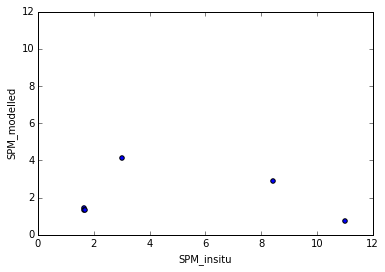

In [39]:
fig, ax = plt.subplots()

x, y = [],[]
for k in data["mean_joined_data"]:
    x.append(data["mean_joined_data"][k]['SPM_insitu'])
    y.append(data["mean_joined_data"][k]['SPM_Nechad_Elinas'])
ax.set_xlabel("SPM_insitu")   
ax.set_ylabel("SPM_modelled")#turbidity_Nechad
 
plt.scatter(x= x, y=y)
plt.axis([0, 12, 0, 12])


In [32]:
# converting to Pandas Dataframe for easy visualization and easy export of the table
results_df = pd.DataFrame(data["mean_joined_data"])
results_df 

20100818            20100820  20110715             \
                            B1        H2        H2      So10       So11   
SPM_Elinas            2.004796  1.239702  1.368754  5.922446  11.914146   
SPM_Nechad_Elinas     1.347571  1.330242  1.457223  2.902432   0.737857   
SPM_insitu            1.660000  1.670000  1.650000  8.440000  10.990000   
TURBIDITY_INSITU      2.220000  1.390000  1.530000  6.470000  12.970000   
rho_w_06              0.006148  0.006048  0.006773  0.014550   0.002568   
turbidity_Nechad_620  1.507019  1.488221  1.625974  3.193786   0.845581   

                                
                          So32  
SPM_Elinas            4.134154  
SPM_Nechad_Elinas     4.144273  
SPM_insitu            3.010000  
TURBIDITY_INSITU      4.530000  
rho_w_06              0.020602  
turbidity_Nechad_620  4.540978

In [33]:
filename = "/home/jobel/Dropbox/ElinasPaper/data_4_elina/Results/MERIS_Turbidity_vs_Insitu_centroids_"+ windowSize +'x'+windowSize +'_'+processor +'.txt'
results_df.to_csv(filename, sep="\t")

# Calculating the Mean Normalized Bias and The RMS of the Relative Differences

In [34]:
Math(r'\textbf{MNB}= \textbf{mean} \left[\frac{y_{i}^{MERIS}- x_{i}^{insitu}}{x_{i}^{insitu}} \right] \times 100')

In [35]:
Math(r'\textbf{RMS}_{RD}= \textbf{stdev} \left[\frac{y_{i}^{MERIS}- x_{i}^{insitu}}{x_{i}^{insitu}} \right] \times 100')

## Turbidity insitu vs Elinas calculated and MERIS Nechad

In [36]:
RD = []
for key in data["mean_joined_data"].keys():
    insitu = data["mean_joined_data"][key]['TURBIDITY_INSITU']
    Meris = data["mean_joined_data"][key]["turbidity_Nechad_620"]
    RD.append( (Meris - insitu) / insitu)
MNB = np.array(RD).mean() * 100
RMS = np.array(RD).std() * 100
NOBS = len(RD)
print ("turbidity_Nechad_620: "+ windowSize +'x'+windowSize +', Processor: '+ processor+ ", MNB: "+ str(MNB)+ ", RMS: "+ str(RMS)+ ", NOBS: "+ str(NOBS))

turbidity_Nechad_620: 3x3, Processor: MEGS, MNB: -27.1087261373, RMS: 36.5472315259, NOBS: 6


In [34]:
RD = []
for key in data["mean_joined_data"].keys():
    insitu = data["mean_joined_data"][key]['SPM_insitu']
    Meris = data["mean_joined_data"][key]["SPM_Nechad_Elinas"]
    RD.append( (Meris - insitu) / insitu)
MNB = np.array(RD).mean() * 100
RMS = np.array(RD).std() * 100
NOBS = len(RD)
print ("SPM_Nechad_Elinas: "+ windowSize +'x'+windowSize +', Processor: '+ processor+ ", MNB: "+ str(MNB)+ ", RMS: "+ str(RMS)+ ", NOBS: "+ str(NOBS))

SPM_Nechad_Elinas: 3x3, Processor: MEGS, MNB: -28.6771548463, RMS: 41.6283541416, NOBS: 6


In [35]:
RD = []
for key in data["mean_joined_data"].keys():
    insitu = data["mean_joined_data"][key]['SPM_insitu']
    Meris = data["mean_joined_data"][key]["SPM_Elinas"]
    RD.append( (Meris - insitu) / insitu)
MNB = np.array(RD).mean() * 100
RMS = np.array(RD).std() * 100
NOBS = len(RD)
print ("SPM_Elinas: "+ windowSize +'x'+windowSize +', Processor: '+ processor+ ", MNB: "+ str(MNB)+ ", RMS: "+ str(RMS)+ ", NOBS: "+ str(NOBS))

SPM_Elinas: 3x3, Processor: MEGS, MNB: -1.0188790255, RMS: 24.9497330619, NOBS: 6


# Validating with MERIS datasets from 2010 and 2008 match-up time window of 2 hours

In [36]:
# Creating the pins_dictionay
#
pinSrcDir = '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_4_validation/'
pin_dict = get_pins_dict(pinSrcDir)

In [37]:
# Filtering the available meris files and pin files based on Beltran-Abaunza et al (2014).
matched_files = {}
meris_matchups_dates = ["20080709","20080715","20080718","20080724","20080725","20080728","20080730","20080731",
                        "20100505","20100511","20100518","20100520","20100524","20100820"]
for date_string in meris_matchups_dates:
    pin_file = pin_dict[date_string]
    matched_files[date_string] = {'MERIS':srcDates[date_string]['filepath'], 'PIN_FILE':pin_file}
    #
matched_files

{'20080709': {'MERIS': '/media/jobel/SeagateDrive/eodata2014/level2/MEGS/20080709_092524/output/MER_FSG_2PNMAP20080709_092524_000000392070_00122_33242_0001.nc',
  'PIN_FILE': '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_4_validation/pin_20080709_Asko2008.placemark'},
 '20080715': {'MERIS': '/media/jobel/SeagateDrive/eodata2014/level2/MEGS/20080715_093646/output/MER_FSG_2PNMAP20080715_093646_000000392070_00208_33328_0001.nc',
  'PIN_FILE': '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_4_validation/pin_20080715_Asko2008.placemark'},
 '20080718': {'MERIS': '/media/jobel/SeagateDrive/eodata2014/level2/MEGS/20080718_094226/output/MER_FSG_2PNMAP20080718_094226_000000422070_00251_33371_0001.nc',
  'PIN_FILE': '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pins_4_validation/pin_20080718_Asko2008.placemark'},
 '20080724': {'MERIS': '/media/jobel/SeagateDrive/eodata2014/level2/MEGS/20080724_095349/output/MER_FRG_2PNMAP20080724_095349_000000422070_00337_33457_0001.nc',
  'PIN_FILE': '/h

In [38]:
"""
__credits__ = ["José M. Beltrán"]
__license__ = "GPL-3.0"
__created_on__ = ["2012-05-03"]

"""

def build_PixEx_graph(meris_filepath, coordinatesFile, outputDir, windowSize, prefix):

    '''
    Builds an XML request skeleton for the Pixel Extration operator of the
    BEAM Software (www.brockmann-consult.com)

    inputhPaths:        input path/filename for pixel extraction
    coordinatesFile:    input pin file that contains the coordinates Lat Lon for
                        pixel extraction
    outputDir:          output directory default 
    windowSize      :   square matrix that defines the window Size around the
                        pixel being exported                        
    '''
    
    requestSkeleton =   '<graph id=\"SU_BC_WaterS\">\n<version>1.0</version>\n'
    requestSkeleton +=  '   <node id=\"PIXEL_EXTRACTION\">\n'
    requestSkeleton +=  '       <operator>PixEx</operator>\n'
    requestSkeleton +=  '       <parameters>\n'
    requestSkeleton +=  '           <timeDifference/>\n'
    requestSkeleton +=  '           <matchupFile/>\n'
    requestSkeleton +=  '           <expression/>\n'
    requestSkeleton +=  '           <aggregatorStrategyType>no aggregation</aggregatorStrategyType>\n'
    requestSkeleton +=  '           <extractTimeFromFilename>false</extractTimeFromFilename>\n'
    requestSkeleton +=  '           <dateInterpretationPattern>yyyyMMdd</dateInterpretationPattern>\n'
    requestSkeleton +=  '           <filenameInterpretationPattern>*${startDate}*${endDate}*</filenameInterpretationPattern>\n'
    requestSkeleton +=  '           <exportBands>true</exportBands>\n'
    requestSkeleton +=  '           <exportTiePoints>true</exportTiePoints>\n'
    requestSkeleton +=  '           <exportMasks>true</exportMasks>\n'
    requestSkeleton +=  '           <windowSize>' + windowSize + '</windowSize>\n'
    requestSkeleton +=  '           <outputDir>' + outputDir + '</outputDir>\n'
    requestSkeleton +=  '           <outputFilePrefix>'+ prefix +'</outputFilePrefix>\n'
    requestSkeleton +=  '           <sourceProductPaths>' + meris_filepath + '</sourceProductPaths>\n'
    requestSkeleton +=  '           <coordinatesFile>' + coordinatesFile + '</coordinatesFile>\n'
    requestSkeleton +=  '       </parameters>\n'
    requestSkeleton +=  '   </node>\n'
    requestSkeleton +=  '</graph>\n'
    return requestSkeleton

In [39]:
# Initializing varibles for pixel Extraction
current_gpt_graph = '/home/jobel/Dropbox/ElinasPaper/gpt_graph/current_gpt_graph.xml'
destDir = '/home/jobel/Dropbox/ElinasPaper/data_4_elina/pixEX_centroids/MEGS/matchups/'

# CAREFUL not to run again the following block as it will start the pixel extraction batch processing. 
## The block after this will load the data from the pixel extraction. 

In [40]:
from os import remove
from os import system

from beam.gpt_config import beamHome, beamBinDir, gptProcessor

for date_string in matched_files.keys():
    acquisitionDate = date_string   
    print "AcquisitionDate : " + acquisitionDate
    coordinatesFile = matched_files[date_string]['PIN_FILE']
    meris_filepath = matched_files[date_string]['MERIS']
    # You can change the name of the pixel extraction output here_but I like this
    outFilePrefix = 'pixEx_'+date_string +'_centroid_'+ windowSize +'x'+windowSize +'_'+processor +'_'
    # Building the PixEX graph for batch processing..
    # More Magic tricks
    request = build_PixEx_graph(meris_filepath= meris_filepath, coordinatesFile=coordinatesFile, outputDir=destDir, windowSize=windowSize, prefix=outFilePrefix)

    # Request File should not exist yet
    if os.path.exists(current_gpt_graph):
        remove(current_gpt_graph)

    # Only now it is generated
    requestFile = open(current_gpt_graph, 'a')
    requestFile.write(request)
    requestFile.close()

    pixExCommand = gptProcessor + " " + current_gpt_graph
    print "Pixel Extraction: Processing file " + date_string + "\n"
    system(pixExCommand)

print 'Bringing happiness to my friends. Your job is done. Enjoy'


AcquisitionDate : 20080730
Pixel Extraction: Processing file 20080730

AcquisitionDate : 20080731
Pixel Extraction: Processing file 20080731

AcquisitionDate : 20100520
Pixel Extraction: Processing file 20100520

AcquisitionDate : 20080715
Pixel Extraction: Processing file 20080715

AcquisitionDate : 20100524
Pixel Extraction: Processing file 20100524

AcquisitionDate : 20080725
Pixel Extraction: Processing file 20080725

AcquisitionDate : 20080724
Pixel Extraction: Processing file 20080724

AcquisitionDate : 20100505
Pixel Extraction: Processing file 20100505

AcquisitionDate : 20080728
Pixel Extraction: Processing file 20080728

AcquisitionDate : 20080718
Pixel Extraction: Processing file 20080718

AcquisitionDate : 20080709
Pixel Extraction: Processing file 20080709

AcquisitionDate : 20100820
Pixel Extraction: Processing file 20100820

AcquisitionDate : 20100511
Pixel Extraction: Processing file 20100511

AcquisitionDate : 20100518
Pixel Extraction: Processing file 20100518

Bringi

# Loading the Extration files
follows [Method 4 Elina's] Turbidity and SPM validation-Validation_SPM_with_Matchups